## 概要
PCAを使って顔画像の認識をしてみます。  
sklearnに用意されているアメリカの有名人の顔画像から、「顔画像を識別」するためのモデルを生成します。  
今回はkNNとPCAを使っているのですが、どちらも精度はせいぜい30%程度でした。  
実用性よりはkNN,PCA,画像を使った機械学習の勉強程度

## 実施日
2017年12月24日(?!)


## 処理の流れ
大まかな流れは下記の通り。  

1.必要な画像の取り込み  
2.データの全体感を確認  
3.誰の顔写真が何枚ずつあるのかをカウント  
4.ちょっとした前処理  
5.kNNで試してみる  
6.pca  
7.PCAの各主成分内容可視化
8.PCAで削減したモデルからinverseして画像を表示


## 参考文献
[Pythonで始める機械学習 scikit-learnで学ぶ特徴量エンジニアリングと機械学習の基礎](https://www.oreilly.co.jp/books/9784873117980/)のp.144-151  
ほとんどそのままのコードを写経しているので、ブログ化する際は注意！


In [8]:
'''1.必要な画像の取り込み
'''


import matplotlib.pyplot as plt


from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                        subplot_kw = {'xticks':(), 'yticks':()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])


In [9]:
'''2.データの全体感を確認
'''

print('people.images.shape: {}'.format(people.images.shape)) # 3023枚の写真、サイズが87×65ピクセル
print('Number of classes: {}'.format(len(people.target_names))) # 62人分の顔写真

people.images.shape: (3023, 87, 65)
Number of classes: 62


In [17]:
'''3.誰の顔写真が何枚ずつあるのかをカウント
'''
import numpy as np

counts = np.bincount(people.target) # 人ごとにカウント

for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print('{0:25}{1:3}'.format(name, count), end= '          ')
    
    # 3人ずつ改行
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo          39          Alvaro Uribe              35          Amelie Mauresmo           21          
Andre Agassi              36          Angelina Jolie            20          Ariel Sharon              77          
Arnold Schwarzenegger     42          Atal Bihari Vajpayee      24          Bill Clinton              29          
Carlos Menem              21          Colin Powell             236          David Beckham             31          
Donald Rumsfeld          121          George Robertson          22          George W Bush            530          
Gerhard Schroeder        109          Gloria Macapagal Arroyo   44          Gray Davis                26          
Guillermo Coria           30          Hamid Karzai              22          Hans Blix                 39          
Hugo Chavez               71          Igor Ivanov               20          Jack Straw                28          
Jacques Chirac            52          Jean Chretien             55          Jenn

In [19]:
'''4.ちょっとした前処理
偏りを減らすために、各人の画像枚数を50に減らす。
そうしないと特徴抽出量が「George W Bush 」のの特徴量に偏ってしまう
'''

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
    
x_people = people.data[mask]
y_people = people.target[mask]


# 0-255で表現されているので、これを0-1スケールに変換(数値を安定させるため)
x_people = x_people / 255.


In [24]:
'''5.kNNで試してみる
顔画像認識の場合、各人の画像数は少ないことが一般的なので訓練が難しい。
更に、新しい人を追加したい場合は「大きなモデルを再訓練」する必要があって面倒臭い。
上記を考慮して、とりあえずknnで最近の１クラスから分類することを考える。
'''

from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
 
## チューニングするパラメータ
tuned_parameters ={ 'n_neighbors': [1] } # パラメータを色々調節する用

# 交差検証を実施。最適な木の深さを確認する。
clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, scoring="accuracy",cv=5, n_jobs=-1)
clf = clf.fit(x_people, y_people) # モデル作成!

# 精度を確認
for params, mean_score, all_scores in clf.grid_scores_:
        print ("{0},精度:{1} ,標準誤差=(+/- {2}) ".format(params, round((mean_score),3), round((all_scores.std() / 2),3))) 

{'n_neighbors': 1},精度:0.252 ,標準誤差=(+/- 0.007) 


In [42]:
'''6.pca
1-knnだと精度は「精度:0.252 」だった。
完全ランダムにやるよりはいい精度かもしれないがもう少しよくならないものかね...。
よく考えたら、ここまでは特徴量を削減していないので、特徴量削減をした方が距離計算する上でいい感じになるのでは？

画像で距離計算すると、同じ画像でも全てのピクセルが１ピクセル横にずれただけで距離が大きく異なるし。

とりあえず100個くらいに特徴量を削減して画像認識精度を確かめてみるか
'''

from sklearn.decomposition import PCA

# 訓練用データと検証用データに分割
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_people, y_people, stratify=y_people, random_state=0)

# クラス生成
pca = PCA(n_components=100, whiten=True, random_state=0).fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# PCAした後のデータを確認(1547の画像に対し、100個の特徴量)
print('x_train_pca.shape: {}'.format(x_train_pca.shape))

# knnに突っ込む
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train_pca, y_train)

# 精度を確認
print('Test set accuracy: {:.2f}'.format(knn.score(x_test_pca, y_test)))

x_train_pca.shape: (1547, 100)
Test set accuracy: 0.31


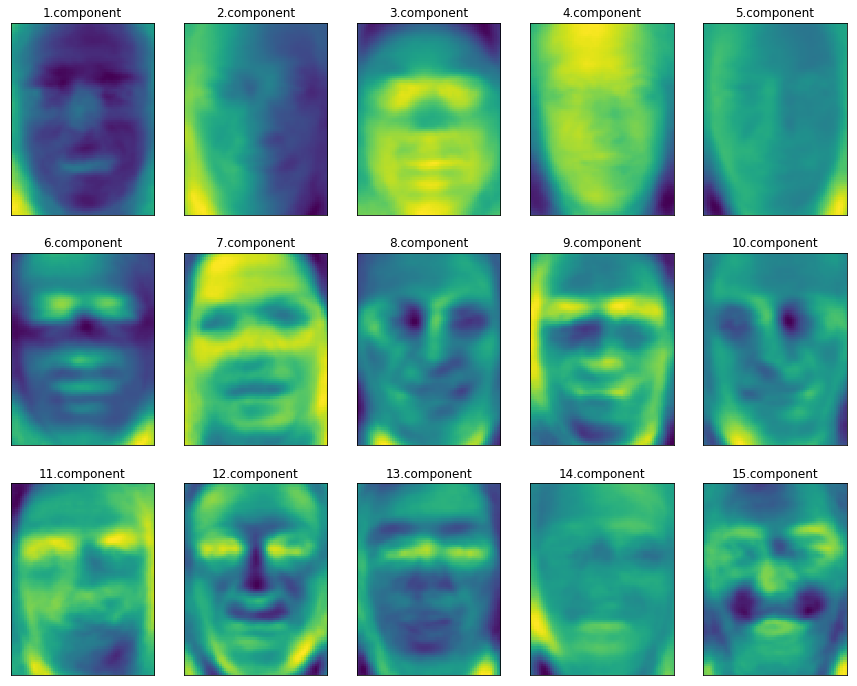

In [32]:
'''7.PCAの各主成分内容可視化
精度が向上したので、主成分分析をした結果よりより顔認識ができていると言える。
折角なので、各主成分を可視化してみよう。
見てみたけど、正直これだけじゃ各主成分がどのような特徴を捉えているのかはわからないよね...。
「光の当たり方」をある程度重要視しているみたいだけど、これは人間による認識とはやっぱり異なるね。
'''


%matplotlib inline

# 3行５列で表示する。
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                        subplot_kw={'xticks':(), 'yticks': ()})


#  元の画像の形式に変換し、タイトルをつけて表示
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    
    ax.imshow(component.reshape(image_shape),
                        cmap='viridis')
    ax.set_title("{}.component".format((i + 1)))


(1547, 100)
(1547, 5655)


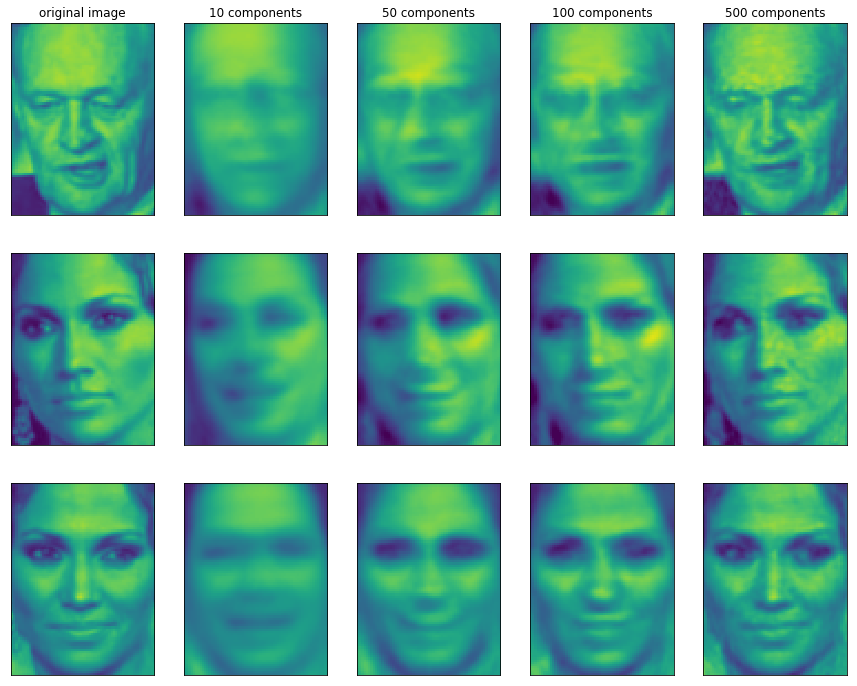

In [43]:
'''8.PCAで削減したモデルからinverseして画像を表示
'''

# inverseってこう書けばできるよ。でも今回は使わないよ。なぜなら、下記のクラスで裏っかわでやっておいてくれるからね。
x_train_pca_inverse = pca.inverse_transform(x_train_pca)
print(x_train_pca.shape)
print(x_train_pca_inverse.shape)

# オリジナル画像、主成分を10,50,100,500個に絞り込んだ場合の顔画像を表示
# https://github.com/amueller/introduction_to_ml_with_python/blob/master/mglearn/plot_pca.py
# trainでPCAモデルを生成し、testをそのモデルにツッコミ、inverseしたものを、image_shapesの形で表現
mglearn.plots.plot_pca_faces(x_train, x_test, image_shape)
